In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.applications.resnet50 import preprocess_input
import numpy as np
import os
import pandas as pd

# Load pre-trained ResNet50 model
resnet_model = ResNet50(weights='imagenet', include_top=False, pooling='avg')

def extract_features(image_path):
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    features = resnet_model.predict(img_array)
    return features.flatten()

# Define directories and categories
base_dir = '/content/drive/My Drive/DATA'
categories = ['boho', 'e-girl', 'oldmoney']
clothing_types = ['tops', 'skirts', 'pants', 'outfits']

data = []

for category in categories:
    for clothing_type in clothing_types:
        folder_path = os.path.join(base_dir, category, clothing_type)
        if os.path.exists(folder_path):
            for filename in os.listdir(folder_path):
                if filename.endswith(('jpg', 'jpeg', 'png')):
                    image_path = os.path.join(folder_path, filename)
                    features = extract_features(image_path)
                    data.append([image_path, category, clothing_type] + features.tolist())

# Convert to DataFrame and save to CSV
df = pd.DataFrame(data, columns=['image_path', 'category', 'clothing_type'] + [f'feature_{i}' for i in range(len(data[0]) - 3)])
df.to_csv('/content/drive/My Drive/clothing_features.csv', index=False)


1/1 [==============================] - 0s 177ms/step


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

# Load the features
df = pd.read_csv('/content/drive/My Drive/clothing_features.csv')
features = df.iloc[:, 4:].values

# Compute similarity matrix
similarity_matrix = cosine_similarity(features)

# Save similarity matrix
np.save('/content/drive/My Drive/similarity_matrix.npy', similarity_matrix)


In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Load the features
df = pd.read_csv('/content/drive/My Drive/clothing_features.csv')
features = df.iloc[:, 4:].values

# Compute similarity matrix
similarity_matrix = cosine_similarity(features)

# Convert similarity matrix to DataFrame
similarity_df = pd.DataFrame(similarity_matrix)

# Save similarity matrix as CSV file
similarity_df.to_csv('/content/drive/My Drive/similarity_matrix.csv', index=False)

# Display the CSV file
print(similarity_df.head())


        0         1         2         3         4         5         6    \
0  1.000000  0.528141  0.561484  0.556752  0.462482  0.478313  0.475377   
1  0.528141  1.000000  0.547614  0.574325  0.738896  0.737135  0.620566   
2  0.561484  0.547614  1.000000  0.410500  0.556937  0.546161  0.579312   
3  0.556752  0.574325  0.410500  1.000000  0.497298  0.539691  0.495484   
4  0.462482  0.738896  0.556937  0.497298  1.000000  0.816502  0.799143   

        7         8         9    ...       660       661       662       663  \
0  0.462672  0.468270  0.515437  ...  0.428698  0.465319  0.421845  0.478713   
1  0.657429  0.619519  0.479776  ...  0.439538  0.570550  0.517255  0.625636   
2  0.529424  0.539970  0.462030  ...  0.531265  0.509704  0.552576  0.528127   
3  0.496000  0.429372  0.521381  ...  0.330166  0.436323  0.400066  0.440362   
4  0.731998  0.643910  0.456218  ...  0.440141  0.564283  0.495370  0.600805   

        664       665       666       667       668       669  
0  0

In [ ]:
import difflib

def get_recommendations(image_path, df, similarity_matrix, top_n=5):
    if image_path not in df['image_path'].values:
        raise ValueError(f"Image path '{image_path}' not found in DataFrame. Here are some close matches: {difflib.get_close_matches(image_path, df['image_path'].values, n=5)}")

    idx = df[df['image_path'] == image_path].index[0]
    sim_scores = list(enumerate(similarity_matrix[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:top_n+1]  # Exclude the image itself

    recommendations = []
    for i, score in sim_scores:
        recommended_item = df.iloc[i]
        if recommended_item['clothing_type'] in ['tops', 'skirts', 'pants']:
            recommendations.append((recommended_item['image_path'], recommended_item['category'], recommended_item['clothing_type'], score))
    return recommendations

# Example usage with an outfit image path
image_path = '/content/drive/My Drive/DATA/boho/tops/Image_10 (3).jpg'
try:
    recommendations = get_recommendations(image_path, df, similarity_matrix)
    for rec in recommendations:
        print(f'Path: {rec[0]}, Category: {rec[1]}, Clothing Type: {rec[2]}, Similarity Score: {rec[3]}')
except ValueError as e:
    print(e)


Path: /content/drive/My Drive/DATA/boho/tops/Image_27 (1).jpg, Category: boho, Clothing Type: tops, Similarity Score: 0.6633752465376045
Path: /content/drive/My Drive/DATA/boho/tops/Image_31.jpeg, Category: boho, Clothing Type: tops, Similarity Score: 0.6453992554491178
Path: /content/drive/My Drive/DATA/e-girl/tops/Image_45 (1).jpg, Category: e-girl, Clothing Type: tops, Similarity Score: 0.6420605691663654
Path: /content/drive/My Drive/DATA/boho/pants/Image_27.jpg, Category: boho, Clothing Type: pants, Similarity Score: 0.6247778500807857
Path: /content/drive/My Drive/DATA/boho/skirts/Image_34.jpeg, Category: boho, Clothing Type: skirts, Similarity Score: 0.6231904182458


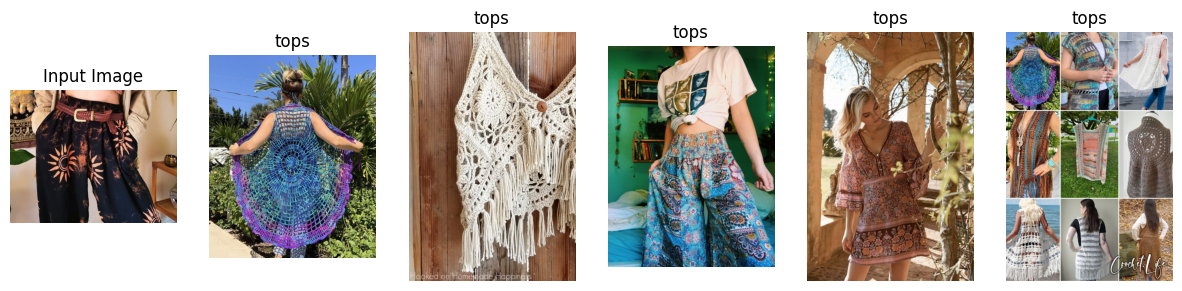

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import difflib
import random

def display_image(image_path, title=None):
    img = mpimg.imread(image_path)
    plt.imshow(img)
    if title:
        plt.title(title)
    plt.axis('off')

def get_recommendations_and_display(image_path, df, similarity_matrix, top_n=5):
    if image_path not in df['image_path'].values:
        close_matches = difflib.get_close_matches(image_path, df['image_path'].values, n=5)
        raise ValueError(f"Image path '{image_path}' not found in DataFrame. Here are some close matches: {close_matches}")

    idx = df[df['image_path'] == image_path].index[0]
    sim_scores = list(enumerate(similarity_matrix[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:]  # Exclude the image itself

    input_category = df.loc[idx, 'category']
    input_clothing_type = df.loc[idx, 'clothing_type']

    # Define complementary clothing types
    complementary_types = {
        'tops': ['skirts', 'pants'],
        'skirts': ['tops'],
        'pants': ['tops']
    }

    if input_clothing_type not in complementary_types:
        raise ValueError(f"Clothing type '{input_clothing_type}' not supported for recommendations.")

    # Filter recommendations based on category and complementary clothing types
    possible_recommendations = [
        (df.iloc[i]['image_path'], df.iloc[i]['category'], df.iloc[i]['clothing_type'])
        for i, score in sim_scores
        if df.iloc[i]['category'] == input_category and df.iloc[i]['clothing_type'] in complementary_types[input_clothing_type]
    ]

    # Randomly select top_n recommendations
    recommendations = random.sample(possible_recommendations, min(top_n, len(possible_recommendations)))

    # Display the input image
    plt.figure(figsize=(15, 5))
    plt.subplot(1, top_n + 1, 1)
    display_image(image_path, title='Input Image')

    # Display recommended images
    for idx, rec in enumerate(recommendations):
        plt.subplot(1, top_n + 1, idx + 2)
        display_image(rec[0], title=f'{rec[2]}')

    plt.show()

# Example usage with an outfit image path
image_path = '/content/drive/My Drive/DATA/boho/pants/Image_15.jpg'
try:
    get_recommendations_and_display(image_path, df, similarity_matrix)
except ValueError as e:
    print(e)


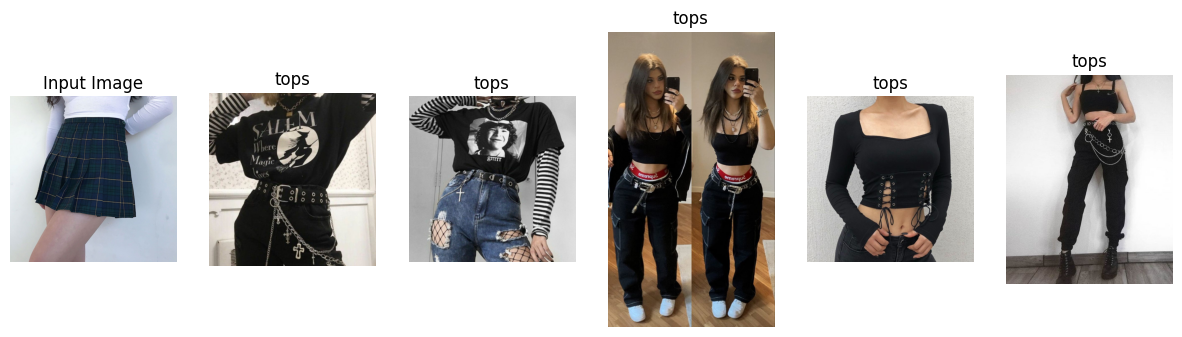

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import difflib
import random

def display_image(image_path, title=None):
    img = mpimg.imread(image_path)
    plt.imshow(img)
    if title:
        plt.title(title)
    plt.axis('off')

def get_recommendations_and_display(image_path, df, similarity_matrix, top_n=5):
    if image_path not in df['image_path'].values:
        close_matches = difflib.get_close_matches(image_path, df['image_path'].values, n=5)
        raise ValueError(f"Image path '{image_path}' not found in DataFrame. Here are some close matches: {close_matches}")

    idx = df[df['image_path'] == image_path].index[0]
    sim_scores = list(enumerate(similarity_matrix[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:]  # Exclude the image itself

    input_category = df.loc[idx, 'category']
    input_clothing_type = df.loc[idx, 'clothing_type']

    # Define complementary clothing types
    complementary_types = {
        'tops': ['skirts', 'pants'],
        'skirts': ['tops'],
        'pants': ['tops']
    }

    if input_clothing_type not in complementary_types:
        raise ValueError(f"Clothing type '{input_clothing_type}' not supported for recommendations.")

    # Filter recommendations based on category and complementary clothing types
    possible_recommendations = [
        (df.iloc[i]['image_path'], df.iloc[i]['category'], df.iloc[i]['clothing_type'])
        for i, score in sim_scores
        if df.iloc[i]['category'] == input_category and df.iloc[i]['clothing_type'] in complementary_types[input_clothing_type]
    ]

    # Randomly select top_n recommendations
    recommendations = random.sample(possible_recommendations, min(top_n, len(possible_recommendations)))

    # Display the input image
    plt.figure(figsize=(15, 5))
    plt.subplot(1, top_n + 1, 1)
    display_image(image_path, title='Input Image')

    # Display recommended images
    for idx, rec in enumerate(recommendations):
        plt.subplot(1, top_n + 1, idx + 2)
        display_image(rec[0], title=f'{rec[2]}')

    plt.show()

# Example usage with an outfit image path
image_path = '/content/drive/My Drive/DATA/e-girl/skirts/Image_17.jpg'
try:
    get_recommendations_and_display(image_path, df, similarity_matrix)
except ValueError as e:
    print(e)
